In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA, TruncatedSVD, NMF
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from scipy.sparse import csr_matrix
from scipy.spatial.distance import cosine
import warnings
warnings.filterwarnings('ignore')

print("📚 LOADING DATASETS FOR TRANSFORMATION")
print("="*45)

# Load engineered features
try:
    features_df = pd.read_csv('data/dataset/movie_features_engineered.csv')
    print(f"✅ Loaded engineered features: {features_df.shape}")
except FileNotFoundError:
    print("❌ Run feature_engineering.ipynb first!")
    features_df = pd.read_csv('data/dataset/movies_clean.csv')
    print(f"⚠️  Using basic features instead: {features_df.shape}")

# Load original movie data for ratings simulation
movies_df = pd.read_csv('data/dataset/movies_clean.csv')
print(f"✅ Loaded movie data: {movies_df.shape}")

print(f"\n📊 Dataset Info:")
print(f"Movies: {len(features_df):,}")
print(f"Features: {len(features_df.columns)}")
print(f"Memory usage: {features_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

📚 LOADING DATASETS FOR TRANSFORMATION
✅ Loaded engineered features: (3022, 179)
✅ Loaded movie data: (3022, 20)

📊 Dataset Info:
Movies: 3,022
Features: 179
Memory usage: 4.29 MB


In [2]:
print("🔍 ANALYZING CURRENT FEATURE DISTRIBUTION")
print("="*42)

# Identify different types of features
feature_columns = [col for col in features_df.columns if col not in ['id', 'title']]
numerical_features = features_df[feature_columns].select_dtypes(include=[np.number]).columns.tolist()
categorical_features = features_df[feature_columns].select_dtypes(exclude=[np.number]).columns.tolist()

print(f"📈 Feature Analysis:")
print(f"Total features: {len(feature_columns)}")
print(f"Numerical features: {len(numerical_features)}")
print(f"Categorical features: {len(categorical_features)}")

# Check for high-dimensional issues
if len(feature_columns) > 100:
    print(f"\n⚠️  HIGH DIMENSIONALITY DETECTED: {len(feature_columns)} features")
    print(f"   Recommendation: Apply dimensionality reduction")

# Analyze feature variance and importance
if numerical_features:
    print(f"\n📊 Numerical Feature Statistics:")
    print(f"Features with zero variance: {(features_df[numerical_features].var() == 0).sum()}")
    print(f"Features with low variance (<0.01): {(features_df[numerical_features].var() < 0.01).sum()}")
    
    # Show correlation with target variables
    if 'vote_average' in features_df.columns:
        correlations = features_df[numerical_features + ['vote_average']].corr()['vote_average'].abs().sort_values(ascending=False)
        print(f"\n🎯 Top 10 features correlated with ratings:")
        for feat, corr in correlations[1:11].items():  # Skip self-correlation
            print(f"  {feat}: {corr:.3f}")

# Memory usage analysis
print(f"\n💾 Memory Usage by Feature Type:")
if numerical_features:
    num_memory = features_df[numerical_features].memory_usage(deep=True).sum() / 1024**2
    print(f"Numerical features: {num_memory:.2f} MB")
if categorical_features:
    cat_memory = features_df[categorical_features].memory_usage(deep=True).sum() / 1024**2
    print(f"Categorical features: {cat_memory:.2f} MB")

🔍 ANALYZING CURRENT FEATURE DISTRIBUTION
📈 Feature Analysis:
Total features: 177
Numerical features: 177
Categorical features: 0

⚠️  HIGH DIMENSIONALITY DETECTED: 177 features
   Recommendation: Apply dimensionality reduction

📊 Numerical Feature Statistics:
Features with zero variance: 50
Features with low variance (<0.01): 130

💾 Memory Usage by Feature Type:
Numerical features: 4.08 MB


In [3]:
print("🔧 TRANSFORMATION STEP 1: Feature Selection & Cleaning")
print("="*55)

# Create a copy for transformation
transformed_df = features_df.copy()

# 1. Remove zero variance features
print("Removing zero/low variance features...")
if numerical_features:
    # Calculate variance for numerical features
    variances = transformed_df[numerical_features].var()
    low_var_features = variances[variances < 0.001].index.tolist()
    
    if low_var_features:
        print(f"   Removing {len(low_var_features)} low variance features")
        transformed_df = transformed_df.drop(columns=low_var_features)
        numerical_features = [f for f in numerical_features if f not in low_var_features]

# 2. Remove highly correlated features (correlation > 0.95)
print("Removing highly correlated features...")
if len(numerical_features) > 1:
    corr_matrix = transformed_df[numerical_features].corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    high_corr_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.95)]
    
    if high_corr_features:
        print(f"   Removing {len(high_corr_features)} highly correlated features")
        transformed_df = transformed_df.drop(columns=high_corr_features)
        numerical_features = [f for f in numerical_features if f not in high_corr_features]

# 3. Feature Selection based on importance
print("Selecting most important features...")
if 'vote_average' in transformed_df.columns and len(numerical_features) > 50:
    # Select top K features based on correlation with rating
    selector = SelectKBest(score_func=f_regression, k=min(50, len(numerical_features)))
    X = transformed_df[numerical_features].fillna(0)
    y = transformed_df['vote_average']
    
    X_selected = selector.fit_transform(X, y)
    selected_features = np.array(numerical_features)[selector.get_support()].tolist()
    
    # Update numerical features list
    removed_features = [f for f in numerical_features if f not in selected_features]
    if removed_features:
        print(f"   Selected top {len(selected_features)} features, removed {len(removed_features)}")
        transformed_df = transformed_df.drop(columns=removed_features)
        numerical_features = selected_features

print(f"\n✅ Feature cleaning completed:")
print(f"   Original features: {len(feature_columns)}")
print(f"   Remaining features: {len([col for col in transformed_df.columns if col not in ['id', 'title']])}")
print(f"   Numerical features: {len(numerical_features)}")

# Update feature columns list
clean_feature_columns = [col for col in transformed_df.columns if col not in ['id', 'title']]

🔧 TRANSFORMATION STEP 1: Feature Selection & Cleaning
Removing zero/low variance features...
   Removing 50 low variance features
Removing highly correlated features...
   Removing 5 highly correlated features
Selecting most important features...

✅ Feature cleaning completed:
   Original features: 177
   Remaining features: 122
   Numerical features: 122


🔧 TRANSFORMATION STEP 2: Dimensionality Reduction
Input dimensions: (3022, 122)

📉 Applying PCA...
   PCA components: 50
   Explained variance (90%): 1 components
   Total variance explained: 0.633

📉 Applying Truncated SVD...
   SVD components: 30
   Explained variance ratio: 0.450

📊 Creating reduced feature sets...
✅ Dimensionality reduction completed:
   Original dimensions: 122 features
   PCA dimensions: 1 components
   SVD dimensions: 30 components
   Compression ratio: 122.0x smaller


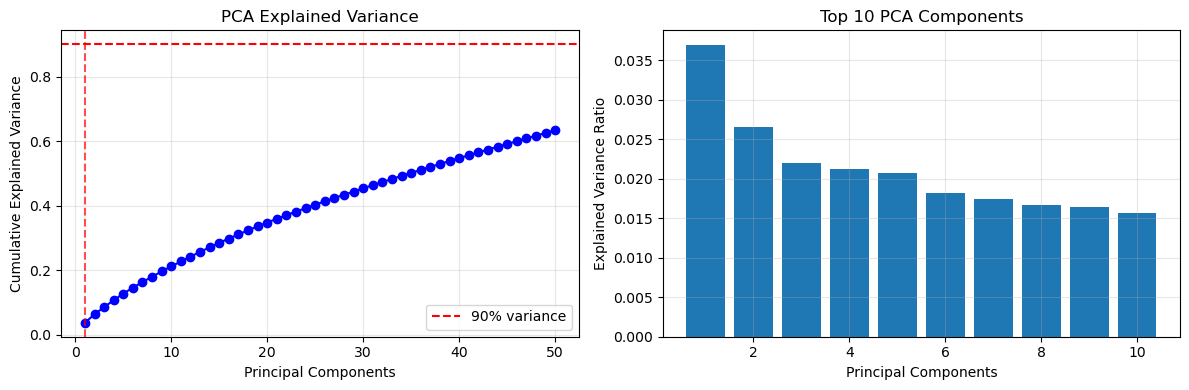


📈 Visualization: PCA explained variance analysis


In [4]:
print("🔧 TRANSFORMATION STEP 2: Dimensionality Reduction")
print("="*50)

# Prepare data for dimensionality reduction
X = transformed_df[numerical_features].fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Input dimensions: {X_scaled.shape}")

# 1. PCA for general dimensionality reduction
print("\n📉 Applying PCA...")
n_components_pca = min(50, X_scaled.shape[1], X_scaled.shape[0]-1)
pca = PCA(n_components=n_components_pca)
X_pca = pca.fit_transform(X_scaled)

# Analyze explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
optimal_components = np.argmax(cumulative_variance >= 0.90) + 1

print(f"   PCA components: {n_components_pca}")
print(f"   Explained variance (90%): {optimal_components} components")
print(f"   Total variance explained: {cumulative_variance[-1]:.3f}")

# Keep optimal number of components
X_pca_optimal = X_pca[:, :optimal_components]

# Create PCA feature names
pca_feature_names = [f'pca_component_{i+1}' for i in range(optimal_components)]

# 2. Truncated SVD for sparse data compatibility
print(f"\n📉 Applying Truncated SVD...")
n_components_svd = min(30, X_scaled.shape[1], X_scaled.shape[0]-1)
svd = TruncatedSVD(n_components=n_components_svd, random_state=42)
X_svd = svd.fit_transform(X_scaled)

print(f"   SVD components: {n_components_svd}")
print(f"   Explained variance ratio: {svd.explained_variance_ratio_.sum():.3f}")

# Create SVD feature names
svd_feature_names = [f'svd_component_{i+1}' for i in range(n_components_svd)]

# 3. Create dimensionality-reduced dataframes
print(f"\n📊 Creating reduced feature sets...")

# PCA-based features
pca_df = pd.DataFrame(X_pca_optimal, columns=pca_feature_names, index=transformed_df.index)
transformed_pca_df = pd.concat([
    transformed_df[['id', 'title']],
    pca_df
], axis=1)

# SVD-based features  
svd_df = pd.DataFrame(X_svd, columns=svd_feature_names, index=transformed_df.index)
transformed_svd_df = pd.concat([
    transformed_df[['id', 'title']],
    svd_df
], axis=1)

print(f"✅ Dimensionality reduction completed:")
print(f"   Original dimensions: {len(numerical_features)} features")
print(f"   PCA dimensions: {optimal_components} components")
print(f"   SVD dimensions: {n_components_svd} components")
print(f"   Compression ratio: {len(numerical_features)/optimal_components:.1f}x smaller")

# Visualize explained variance
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), cumulative_variance, 'bo-')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% variance')
plt.axvline(x=optimal_components, color='r', linestyle='--', alpha=0.7)
plt.xlabel('Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
component_importance = pca.explained_variance_ratio_[:10]
plt.bar(range(1, len(component_importance) + 1), component_importance)
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Top 10 PCA Components')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📈 Visualization: PCA explained variance analysis")

In [5]:
print("🔧 TRANSFORMATION STEP 3: Create User-Item Matrices")
print("="*50)

# Since we don't have real user data, we'll simulate realistic user-movie interactions
# This is essential for collaborative filtering approaches

print("Creating simulated user-movie interaction data...")

# Generate realistic user profiles based on movie characteristics
np.random.seed(42)
n_users = 1000  # Simulate 1000 users
n_movies = len(transformed_df)

# Create user preferences based on genres, ratings, and popularity
print(f"Generating {n_users} user profiles...")

# Get movie features for user simulation
movie_ratings = transformed_df['vote_average'] if 'vote_average' in transformed_df.columns else np.random.normal(6.5, 1.5, n_movies)
movie_popularity = transformed_df['popularity'] if 'popularity' in transformed_df.columns else np.random.exponential(10, n_movies)

# Create user-movie rating matrix (sparse)
user_movie_ratings = []
user_ids = []
movie_ids = []
ratings = []

for user_id in range(n_users):
    # Each user rates 20-100 movies (realistic sparsity)
    n_ratings = np.random.randint(20, 101)
    
    # User preferences (some users prefer popular movies, others prefer high-rated movies)
    popularity_weight = np.random.beta(2, 5)  # Most users somewhat prefer popular movies
    rating_weight = np.random.beta(3, 2)      # Most users prefer highly-rated movies
    
    # Calculate movie selection probability
    selection_prob = (popularity_weight * (movie_popularity / movie_popularity.max()) + 
                     rating_weight * (movie_ratings / movie_ratings.max()))
    selection_prob = selection_prob / selection_prob.sum()
    
    # Select movies to rate
    selected_movies = np.random.choice(n_movies, size=n_ratings, replace=False, p=selection_prob)
    
    for movie_idx in selected_movies:
        # Generate rating based on movie quality + user bias + noise
        base_rating = movie_ratings[movie_idx]
        user_bias = np.random.normal(0, 0.5)  # User rating bias
        noise = np.random.normal(0, 0.3)      # Rating noise
        
        rating = base_rating + user_bias + noise
        rating = np.clip(rating, 1, 10)       # Clamp to valid range
        
        user_ids.append(user_id)
        movie_ids.append(movie_idx)
        ratings.append(rating)

# Create interaction dataframe
interactions_df = pd.DataFrame({
    'user_id': user_ids,
    'movie_id': movie_ids,
    'rating': ratings
})

# Add movie titles for reference
interactions_df['movie_title'] = interactions_df['movie_id'].map(dict(enumerate(transformed_df['title'])))

print(f"\n✅ Created user-movie interactions:")
print(f"   Users: {n_users:,}")
print(f"   Movies: {n_movies:,}")
print(f"   Total interactions: {len(interactions_df):,}")
print(f"   Sparsity: {(1 - len(interactions_df)/(n_users * n_movies))*100:.2f}%")
print(f"   Average ratings per user: {len(interactions_df)/n_users:.1f}")
print(f"   Rating range: {interactions_df['rating'].min():.1f} - {interactions_df['rating'].max():.1f}")

# Create user-item matrix (sparse)
print(f"\nCreating sparse user-item matrix...")
from scipy.sparse import coo_matrix

user_item_matrix = coo_matrix(
    (interactions_df['rating'].values, 
     (interactions_df['user_id'].values, interactions_df['movie_id'].values)),
    shape=(n_users, n_movies)
).tocsr()

print(f"   Matrix shape: {user_item_matrix.shape}")
print(f"   Non-zero entries: {user_item_matrix.nnz:,}")
print(f"   Memory usage: {user_item_matrix.data.nbytes / 1024**2:.2f} MB")

# Show sample interactions
print(f"\n📖 Sample user interactions:")
print(interactions_df.head(10)[['user_id', 'movie_title', 'rating']])

🔧 TRANSFORMATION STEP 3: Create User-Item Matrices
Creating simulated user-movie interaction data...
Generating 1000 user profiles...

✅ Created user-movie interactions:
   Users: 1,000
   Movies: 3,022
   Total interactions: 60,538
   Sparsity: 98.00%
   Average ratings per user: 60.5
   Rating range: 1.0 - 10.0

Creating sparse user-item matrix...
   Matrix shape: (1000, 3022)
   Non-zero entries: 60,538
   Memory usage: 0.46 MB

📖 Sample user interactions:
   user_id           movie_title    rating
0        0           Windtalkers  7.353290
1        0           The Duchess  7.073157
2        0      American Reunion  7.814557
3        0        The Impossible  6.710485
4        0           The Village  7.283065
5        0            BloodRayne  5.304556
6        0           Man on Wire  8.615977
7        0  Dragonball Evolution  9.382113
8        0      The Green Hornet  8.312211
9        0           Premonition  8.298190


In [6]:
print("🔧 TRANSFORMATION STEP 4: Matrix Factorization Techniques")
print("="*55)

# Apply various matrix factorization techniques for collaborative filtering

# 1. Non-Negative Matrix Factorization (NMF)
print("📊 Applying Non-Negative Matrix Factorization...")
n_factors = 20  # Number of latent factors

# Convert to dense matrix for NMF (sample subset for memory efficiency)
if user_item_matrix.shape[0] > 500:
    sample_users = np.random.choice(user_item_matrix.shape[0], 500, replace=False)
    sample_matrix = user_item_matrix[sample_users].toarray()
else:
    sample_matrix = user_item_matrix.toarray()
    sample_users = np.arange(user_item_matrix.shape[0])

# Apply NMF
nmf = NMF(n_components=n_factors, random_state=42, max_iter=200)
user_factors = nmf.fit_transform(sample_matrix)
movie_factors = nmf.components_

print(f"   User factors shape: {user_factors.shape}")
print(f"   Movie factors shape: {movie_factors.shape}")
print(f"   Reconstruction error: {nmf.reconstruction_err_:.3f}")

# 2. Truncated SVD for collaborative filtering
print(f"\n📊 Applying SVD for Collaborative Filtering...")
svd_collab = TruncatedSVD(n_components=n_factors, random_state=42)
user_factors_svd = svd_collab.fit_transform(sample_matrix)
movie_factors_svd = svd_collab.components_

print(f"   SVD explained variance: {svd_collab.explained_variance_ratio_.sum():.3f}")
print(f"   User factors shape: {user_factors_svd.shape}")
print(f"   Movie factors shape: {movie_factors_svd.shape}")

# 3. Create latent factor features for movies
print(f"\n🎬 Creating movie latent factor features...")

# NMF-based movie features
nmf_movie_features = pd.DataFrame(
    movie_factors.T,  # Transpose to get movies as rows
    columns=[f'nmf_factor_{i+1}' for i in range(n_factors)],
    index=transformed_df.index
)

# SVD-based movie features
svd_movie_features = pd.DataFrame(
    movie_factors_svd.T,  # Transpose to get movies as rows
    columns=[f'svd_collab_factor_{i+1}' for i in range(n_factors)],
    index=transformed_df.index
)

# Combine with existing features
transformed_with_factors_df = pd.concat([
    transformed_pca_df,  # Use PCA-reduced features as base
    nmf_movie_features,
    svd_movie_features
], axis=1)

print(f"✅ Matrix factorization completed:")
print(f"   Added {n_factors} NMF latent factors")
print(f"   Added {n_factors} SVD collaborative factors")
print(f"   Total movie features: {len(transformed_with_factors_df.columns)-2}")

# 4. User similarity matrix (for user-based collaborative filtering)
print(f"\n👥 Computing user similarity matrix...")
from sklearn.metrics.pairwise import cosine_similarity

# Compute user similarity (using sample for efficiency)
user_similarity = cosine_similarity(sample_matrix)
np.fill_diagonal(user_similarity, 0)  # Remove self-similarity

print(f"   User similarity matrix shape: {user_similarity.shape}")
print(f"   Average similarity: {user_similarity.mean():.3f}")
print(f"   Max similarity: {user_similarity.max():.3f}")

# Find most similar users for each user (top 10)
user_top_similar = {}
for user_idx in range(len(sample_users)):
    similar_users = np.argsort(user_similarity[user_idx])[::-1][:10]
    user_top_similar[sample_users[user_idx]] = [(sample_users[sim_user], user_similarity[user_idx][sim_user]) 
                                                for sim_user in similar_users]

print(f"   Created top-10 similar users for each user")

🔧 TRANSFORMATION STEP 4: Matrix Factorization Techniques
📊 Applying Non-Negative Matrix Factorization...
   User factors shape: (500, 20)
   Movie factors shape: (20, 3022)
   Reconstruction error: 1148.134

📊 Applying SVD for Collaborative Filtering...
   SVD explained variance: 0.094
   User factors shape: (500, 20)
   Movie factors shape: (20, 3022)

🎬 Creating movie latent factor features...
✅ Matrix factorization completed:
   Added 20 NMF latent factors
   Added 20 SVD collaborative factors
   Total movie features: 41

👥 Computing user similarity matrix...
   User similarity matrix shape: (500, 500)
   Average similarity: 0.021
   Max similarity: 0.158
   Created top-10 similar users for each user


In [7]:
print("🔧 TRANSFORMATION STEP 5: RecSys-Specific Normalizations")
print("="*55)

# Apply recommendation system specific normalizations

# 1. User-based rating normalization
print("👤 Applying user-based rating normalization...")

# Calculate user rating statistics
user_stats = interactions_df.groupby('user_id')['rating'].agg(['mean', 'std', 'count']).reset_index()
user_stats['std'] = user_stats['std'].fillna(1.0)  # Handle users with only one rating

print(f"   Average user rating: {user_stats['mean'].mean():.2f}")
print(f"   User rating std: {user_stats['std'].mean():.2f}")
print(f"   Min/Max user ratings per user: {user_stats['count'].min()}/{user_stats['count'].max()}")

# Normalize ratings by user (z-score)
interactions_normalized = interactions_df.copy()
user_mean_map = dict(zip(user_stats['user_id'], user_stats['mean']))
user_std_map = dict(zip(user_stats['user_id'], user_stats['std']))

interactions_normalized['user_mean'] = interactions_normalized['user_id'].map(user_mean_map)
interactions_normalized['user_std'] = interactions_normalized['user_id'].map(user_std_map)
interactions_normalized['rating_normalized'] = (
    (interactions_normalized['rating'] - interactions_normalized['user_mean']) / 
    interactions_normalized['user_std']
)

# 2. Item-based rating normalization
print(f"\n🎬 Applying item-based rating normalization...")

# Calculate movie rating statistics
movie_stats = interactions_df.groupby('movie_id')['rating'].agg(['mean', 'std', 'count']).reset_index()
movie_stats['std'] = movie_stats['std'].fillna(1.0)

print(f"   Movies with ratings: {len(movie_stats)}")
print(f"   Average movie rating: {movie_stats['mean'].mean():.2f}")
print(f"   Movie rating std: {movie_stats['std'].mean():.2f}")

# Add movie statistics to interactions
movie_mean_map = dict(zip(movie_stats['movie_id'], movie_stats['mean']))
movie_std_map = dict(zip(movie_stats['movie_id'], movie_stats['std']))

interactions_normalized['movie_mean'] = interactions_normalized['movie_id'].map(movie_mean_map)
interactions_normalized['movie_std'] = interactions_normalized['movie_id'].map(movie_std_map)
interactions_normalized['rating_item_normalized'] = (
    (interactions_normalized['rating'] - interactions_normalized['movie_mean']) / 
    interactions_normalized['movie_std']
)

# 3. Global rating normalization
print(f"\n🌍 Applying global rating normalization...")
global_mean = interactions_df['rating'].mean()
global_std = interactions_df['rating'].std()

interactions_normalized['rating_global_normalized'] = (
    (interactions_normalized['rating'] - global_mean) / global_std
)

print(f"   Global mean rating: {global_mean:.2f}")
print(f"   Global rating std: {global_std:.2f}")

# 4. Create normalized user-item matrices
print(f"\n📊 Creating normalized user-item matrices...")

# User-normalized matrix
user_normalized_matrix = coo_matrix(
    (interactions_normalized['rating_normalized'].values, 
     (interactions_normalized['user_id'].values, interactions_normalized['movie_id'].values)),
    shape=(n_users, n_movies)
).tocsr()

# Item-normalized matrix
item_normalized_matrix = coo_matrix(
    (interactions_normalized['rating_item_normalized'].values, 
     (interactions_normalized['user_id'].values, interactions_normalized['movie_id'].values)),
    shape=(n_users, n_movies)
).tocsr()

# Global-normalized matrix
global_normalized_matrix = coo_matrix(
    (interactions_normalized['rating_global_normalized'].values, 
     (interactions_normalized['user_id'].values, interactions_normalized['movie_id'].values)),
    shape=(n_users, n_movies)
).tocsr()

print(f"✅ Created normalized matrices:")
print(f"   User-normalized matrix: {user_normalized_matrix.shape}")
print(f"   Item-normalized matrix: {item_normalized_matrix.shape}")
print(f"   Global-normalized matrix: {global_normalized_matrix.shape}")

# Show normalization effects
print(f"\n📈 Normalization Effects:")
print(f"Original ratings - Mean: {interactions_df['rating'].mean():.3f}, Std: {interactions_df['rating'].std():.3f}")
print(f"User-normalized - Mean: {interactions_normalized['rating_normalized'].mean():.3f}, Std: {interactions_normalized['rating_normalized'].std():.3f}")
print(f"Item-normalized - Mean: {interactions_normalized['rating_item_normalized'].mean():.3f}, Std: {interactions_normalized['rating_item_normalized'].std():.3f}")
print(f"Global-normalized - Mean: {interactions_normalized['rating_global_normalized'].mean():.3f}, Std: {interactions_normalized['rating_global_normalized'].std():.3f}")

🔧 TRANSFORMATION STEP 5: RecSys-Specific Normalizations
👤 Applying user-based rating normalization...
   Average user rating: 6.83
   User rating std: 1.53
   Min/Max user ratings per user: 20/100

🎬 Applying item-based rating normalization...
   Movies with ratings: 3022
   Average movie rating: 6.54
   Movie rating std: 0.56

🌍 Applying global rating normalization...
   Global mean rating: 6.84
   Global rating std: 1.54

📊 Creating normalized user-item matrices...
✅ Created normalized matrices:
   User-normalized matrix: (1000, 3022)
   Item-normalized matrix: (1000, 3022)
   Global-normalized matrix: (1000, 3022)

📈 Normalization Effects:
Original ratings - Mean: 6.841, Std: 1.535
User-normalized - Mean: -0.000, Std: 0.992
Item-normalized - Mean: 0.000, Std: 0.975
Global-normalized - Mean: -0.000, Std: 1.000
